# Fast three-band cloud masks for Sentinel-2

In [33]:
%matplotlib inline
import datacube
from datacube.storage import masking

import yaml
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import gridspec

from scipy import ndimage
from skimage.morphology import disk

import _pickle as cPickle


# Connect to test datacube and production datacube

In [2]:
dc=datacube.Datacube(config='cloudtest.conf')
prod_dc=datacube.Datacube()

## Only center S2 granules are inspected

This helps to reduce the number of images to inspect and align nbart, maja and s2cloud mask input images

In [3]:
granule_of_interest = ['T55HCU', 'T56HLH', 'T55GDP', 'T54HTG', 'T52KDA', 'T50HMG']

## Spectral bands used for true-color and false-color inspections

In [4]:
#l1c_band_names = {'B02':'blue','B03':'green','B04':'red','B08':'nir','B10':'cirrus','B11':'swir1'}
l1c_band_names = {'B8A':'nir', 'B09':'vapour','B10':'cirrus'}
l1c_band_of_interest = l1c_band_names.keys()
nbart_band_names = {'nbart_blue':'blue','nbart_green':'green','nbart_red':'red',
                    'nbart_nir_1':'nir', 'nbart_swir_2':'swir1'}
nbart_band_of_interest = list(nbart_band_names.keys()) +['fmask']

true_rgb = ['red','green','blue']
false_rgb = ['swir1','nir','green']

# Define area of interest

In [5]:
xylist = [
    ((1100000,1200000), (-4200000,-4100000)),((1700000,1800000), (-3900000,-3800000)),
    ((1200000,1300000), (-4700000,-4600000)),((500000,600000), (-3900000,-3800000)),
    ((-400000,-300000), (-2500000,-2400000)),((-1500000,-1400000), (-3900000,-3800000))
    ]

xylist = [
    ((1150000,1200000), (-4200000,-4150000)),((1750000,1800000), (-3900000,-3850000)),
    ((1250000,1300000), (-4700000,-4650000)),((550000,600000), (-3900000,-3850000)),
    ((-400000,-350000), (-2500000,-2450000)),((-1500000,-1450000), (-3900000,-3850000))
    ]


def extract_data(x, y):
    query = {'x': x, 'y':y, 'resolution':(20, 20),
         'crs': 'EPSG:3577', 'output_crs':'EPSG:3577',
        'time': ('2016-07-01','2017-07-01')}
        
    dss = dc.find_datasets(product='maja_cloud_geo_mask', **query)
    maja_dss = []
    for ds in dss:
        doc=yaml.load(open(ds.local_path))
        if doc['lineage']['source_datasets']['0']['image']['tile_reference'] in granule_of_interest:
            granules = [doc['lineage']['source_datasets']['0']['image']['tile_reference']]
            maja_dss.append(ds)
    
    maja_mask = dc.load(product='maja_cloud_geo_mask', datasets= maja_dss, group_by='solar_day', **query)

    source_dss = {}
    l1c_dss = {}
    for ds in maja_dss:
        doc = yaml.load(open(ds.local_path))
        l1c_ds = prod_dc.index.datasets.get(doc['lineage']['source_datasets']['0']['id'])
        derived = prod_dc.index.datasets.get_derived(l1c_ds.id)
        if len(derived)==1:
            if derived[0].type.name in source_dss.keys():
                source_dss[derived[0].type.name].append(derived[0])
                l1c_dss[l1c_ds.type.name].append(l1c_ds)
            else:
                source_dss[derived[0].type.name]=[derived[0]]
                l1c_dss[l1c_ds.type.name]=[l1c_ds]
                
    l1c_data = None
    for product, datasets in l1c_dss.items():
        l1c_data = prod_dc.load(product=product, measurements=l1c_band_of_interest,
                           datasets=datasets, group_by='solar_day', **query)
        
    l1c_data = l1c_data.rename(l1c_band_names)
    maja_mask = maja_mask.sel(time=l1c_data.time)

    nx, ny = len(l1c_data.x), len(l1c_data.y)
    cirrus_ref_smooth = ndimage.median_filter(l1c_data.cirrus.quantile(0.05, dim='time'), footprint=disk(5))
    cirrus_arr = (l1c_data.cirrus/cirrus_ref_smooth).groupby('time').apply(
        lambda x: ndimage.median_filter(x, footprint=disk(5))).isel(
            x=slice(0,nx,100), y =slice(0,ny,100)).values.ravel()
    vapour_arr = (l1c_data.vapour/l1c_data.nir).groupby('time').apply(
    lambda x: ndimage.uniform_filter(x, size=300)).isel(
            x=slice(0,nx,100), y =slice(0,ny,100)).values.ravel()
    cloud_arr = masking.make_mask(maja_mask.sel(time=l1c_data.time).geo_mask, cloud_not_thinnest = True).isel(
            x=slice(0,nx,100), y =slice(0,ny,100)).values.ravel()
    
    return cirrus_arr, vapour_arr, cloud_arr

cirrus_arr = None
vapour_arr = None
cloud_arr = None

outfile = 'cirrus_train_quantile.pkl'
if not os.path.exists(outfile):
    for x, y in xylist:
        if cirrus_arr is None:
            cirrus_arr, vapour_arr, cloud_arr = extract_data(x, y)
        else:
            arr1, arr2, arr3 = extract_data(x, y)
            cirrus_arr = np.append(cirrus_arr, arr1)
            vapour_arr = np.append(vapour_arr, arr2)
            cloud_arr = np.append(cloud_arr, arr3)
        print(cirrus_arr.shape, vapour_arr.shape, cloud_arr.shape)
        with open(outfile, 'wb') as out:
            cPickle.dump((cirrus_arr, vapour_arr, cloud_arr), out)
   

(18125,) (18125,) (18125,)
(38125,) (38125,) (38125,)
(56875,) (56875,) (56875,)
(86875,) (86875,) (86875,)
(105000,) (105000,) (105000,)
(122500,) (122500,) (122500,)


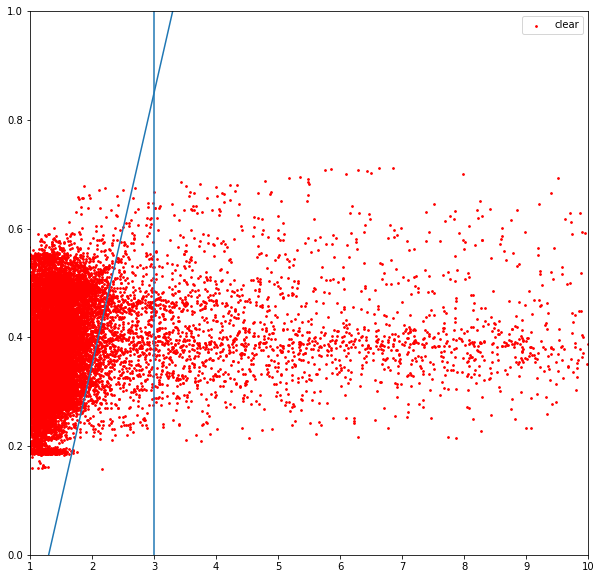

In [112]:
cirrus_arr, vapour_arr, cloud_arr = cPickle.load(open('cirrus_train_quantile.pkl','rb'))
f=plt.figure(figsize=(10,10))
plt.scatter(cirrus_arr[~cloud_arr], vapour_arr[~cloud_arr], color='r', label='clear', s=3)
#plt.scatter(cirrus_arr[cloud_arr], vapour_arr[cloud_arr], color='b', label='cloud', s=3)
plt.legend()
plt.xlim((1,10))
plt.ylim((0,1))
plt.plot(np.array([0,1])*2.+1.3,np.array([0,1]))
plt.axvline(3)

In [115]:
np.sum(cirrus_arr[~cloud_arr] > (vapour_arr[~cloud_arr]*2+1.3))*1./(~np.isnan(cirrus_arr[~cloud_arr])).sum()

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


0.13233448384060245

In [116]:
np.sum(cirrus_arr[cloud_arr] > (vapour_arr[cloud_arr]*2+1.3))*1./(~np.isnan(cirrus_arr[cloud_arr])).sum()

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


0.7662789745269882

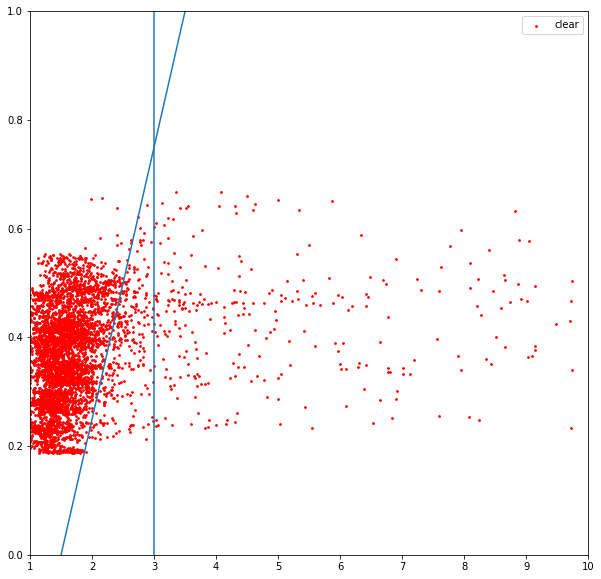

In [109]:
cirrus_arr, vapour_arr, cloud_arr = cPickle.load(open('cirrus_train.pkl','rb'))
f=plt.figure(figsize=(10,10))
plt.scatter(cirrus_arr[~cloud_arr], vapour_arr[~cloud_arr], color='r', label='clear', s=3)
#plt.scatter(cirrus_arr[cloud_arr], vapour_arr[cloud_arr], color='b', label='cloud', s=3)
plt.legend()
plt.xlim((1,10))
plt.ylim((0,1))
plt.plot(np.array([0,1])*2.+1.5,np.array([0,1]))
plt.axvline(3)

In [110]:
np.sum(cirrus_arr[~cloud_arr] > (vapour_arr[~cloud_arr]*2+1.5))*1./(~np.isnan(cirrus_arr[~cloud_arr])).sum()

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


0.13345091122868902

In [111]:
np.sum(cirrus_arr[cloud_arr] > (vapour_arr[cloud_arr]*2+1.5))*1./(~np.isnan(cirrus_arr[cloud_arr])).sum()

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


0.7754364840457556